**<font size=5>Level up your web scraping skills: extracting 2020 presidential election votes from news images</font>**


> Disclaimer: This is not a political blog. This blog is purely intended to be a technical one and doesn't 
> reflect any political opinion from the author. It simply demonstrates how to use images as an unusual
> source of data.

# Motivations

During the presidential election week, we have all been flooded by numbers. The constant repetition of the latest counts was overwhelming. The expectation for a final result was exhausting. To fully understand and probably to assimilate what happened during that week, I felt a desire to review the course of actions. I wanted to (re)view how the counts were updated hours after hours.

I was almost certain to find such numbers easily, but the more I was looking for a website, a RSS feed, any dataset. I soon realized that there were no easy way to find the evolution of vote counts as we experienced it.

If you are looking for the latest vote counts or results in your state, in your county, district, chances are that you'll find well formatted data pretty quickly. But those data only contain the latest counts so far. It doesn't provides a snapshot of what was going on hour by hour.

I eventually found a way to get my hand on such evolution of voting counts by using images from live news media. I long hesitated to publish my findings as the subject is still sensitive. But as a convinced computer vision practitioner, I couldn't resist to share how to extract useful information from images in the most unusual way. I hope that it could be inspirational : images are worth a thousand words after all.

# A quest for data

One source of information I relied on during the election week was a CNN live story. For the best or worst, it was easy to monitor the election results either in deep or just surfacing it time to time.

"When you have a hammer, everything looks like a nail"
After failing at getting the evolution of vote counts, I soon realize all the datas I was looking for were just under my eyes. The CNN livestory was just a collection of posts with video snapshot to illustrate what the latest speaker was saying.

![Post example](imgs/cnn_post_example.png)


Some of the articles in those live stories contain a snapshot of the special election show. And as you can see, there is always a news ticker at the bottom of the screen showing the current votes status. It's even better as it is always located at the same place.

So far, so good. Let's obtain those images! 

# Crawling a dynamic livestory

If you are not interested by that one, I've got you covered. Skip the section, and go to the next one, I have already zipped all the images for you to experiment (look here)

There are only 3 url we are interested in :
- [trump-biden-election-results-11-05-20](https://www.cnn.com/politics/live-news/trump-biden-election-results-11-05-20/index.html)
- [trump-biden-election-results-11-06-20](https://www.cnn.com/politics/live-news/trump-biden-election-results-11-06-20/index.html)
- [trump-biden-election-results-11-07-20](https://www.cnn.com/politics/live-news/trump-biden-election-results-11-07-20/index.html)

Those pages are dynamic. They update while you keep scrolling down. At first, I tough I had to rely on Selenium or similar tools. But, after looking more carefully at it, it sounds like the live story data is downloaded at once, and the posts are later displayed on-demand.

I am using google Chrome. If you open the code inspector while browsing one of those pages, you will notice some Json data downloaded soon after a page refresh.


I am using google Chrome. If you open the code inspector while browsing one of those pages, you will notice some json data downloaded soon after a page refresh.

You are looking for a get request to https://data.api.cnn.io/graphql. Probably not the first call, but the second one.

![graphql](imgs/graphql_1.png)

The response is a json data containing the structure of the livestory. You have all the post with their title, creation date, text and also media (both videos and images)

Best way to download that json is to use curl with the help of the chrome code inspector just copy the curl command.

![graphql2](imgs/graphql_2.png)

You should have something similar to that one

    curl 'https://data.api.cnn.io/graphql' \
	  -H 'authority: data.api.cnn.io' \
	  -H 'pragma: no-cache' \
	  -H 'cache-control: no-cache' \
	  -H 'sec-ch-ua: "Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"' \
	  -H 'accept: */*' \
	  -H 'x-graphql-query-uuid: livestory---PostsWithGraph{"livestory_id":"h_f887fc510d5e8ae829971ae452386965","startId":null}---6cfb637bd4a95bb97e5bd7ba14b0415b7a76d0dfdc83caf87662b319f1354af9' \
	  -H 'sec-ch-ua-mobile: ?0' \
	  -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36' \
	  -H 'x-api-key: P7LEOCujzt2RqSaWBeImz1spIoLq7dep7x983yQc' \
	  -H 'content-type: application/json' \
	  -H 'origin: https://www.cnn.com' \
	  -H 'sec-fetch-site: cross-site' \
	  -H 'sec-fetch-mode: cors' \
	  -H 'sec-fetch-dest: empty' \
	  -H 'referer: https://www.cnn.com/' \
	  -H 'accept-language: en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7' \
	  --data-raw '{"operationName":"PostsWithGraph","variables":{"livestory_id":"h_f887fc510d5e8ae829971ae452386965","startId":null},"query":"query PostsWithGraph($livestory_id: String) {\n  getLivestoryWebData(livestory_id: $livestory_id) {\n    id\n    lastPublishDate\n    lastPublishDateFormatted\n    activityStatus\n    pinnedPosts {\n      id\n      lastPublishDate\n      __typename\n    }\n    unpinnedPosts {\n      id\n      sourceId\n      lastPublishDate\n      lastPublishDateFormatted\n      headline\n      byline\n      content\n      tags\n      __typename\n    }\n    tags\n    __typename\n  }\n}\n"}' \
	  --compressed
      
      
The resulting json provides a lot of informations about the livestory and posts layout. Not everything is relevant, so I filtered out only what's really useful using jq. It's a bit out of the scope of this post so you can find the final filtered json's files there (livestory05.json, livestory06.json, livestory07.json)

I also made available the commands I used [there](
https://raw.githubusercontent.com/grochefort/2020USElection/master/scripts/GetLivestoryJsonWithCurl.sh)

# Explore the images

Let's explore the datas we gathered so far.

In [35]:
import pandas as pd
livestories = ['livestory05.json', 'livestory06.json', 'livestory07.json']

df = pd.concat(pd.read_json(page) for page in livestories)
df.columns = ['id', 'type', 'videoUrl', 'firstPublishedDate', 'videoId', 'thumbUrl']
df = df.set_index('firstPublishedDate')
df = df.sort_index()
df

,id,type,videoUrl,videoId,thumbUrl
firstPublishedDate,,,,,
2020-11-05T12:01:16.375Z,h_9b54de25d37ebe6e7599b5e090221876,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_d46ef277-d870-4430-bef4-e538235e52af,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-05T12:43:32.334Z,h_d36f2d605db615a7471de0c409ab1c54,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_e0ee1919-74a1-4ac9-b2b7-625acd9d2740,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-05T13:25:56.060Z,h_5ca0759f596b78acbd9eb433e0ce673f,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_a78b474f-f1ac-4979-aca6-00ebf46f79d4,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-05T13:39:20.601Z,h_e2466018c2b0e21d3c808718bbc459a6,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_2fe54cdc-12e4-4159-b14b-c4bdf051e868,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-05T13:58:33.989Z,h_cd314dc7e3d0698055d577a30cdb3658,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_ff9e13a7-28d6-46a0-8340-678042468ce6,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
...,...,...,...,...,...
2020-11-08T02:32:48.342Z,h_06c204c600addb2a25163a2108b72451,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_8f9dbe56-d553-4bb7-a865-7701c96d1b95,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-08T02:36:49.235Z,h_cb148521605fdbb48fbdae84ca01202d,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_1cbb2332-3eba-4ff7-a9c7-6c2a883e16e1,https://dynaimage.cdn.cnn.com/cnn/digital-imag...
2020-11-08T03:09:52.899Z,h_a748ba214d974feff43165da99f946dc,video,https://clips-media-aka.warnermediacdn.com/cnn...,video_6f2c76b6-dfef-46c2-bc8b-f9a6a358615a,https://dynaimage.cdn.cnn.com/cnn/digital-imag...


We are mostly interested in the first publication date and the thumbnail url.

In [38]:
from ipyplot import plot_images
plot_images(df.thumbUrl, labels=df.index, max_images=9)

It's now time to download all those images to further process them. You can also follow the code in a jupyter notebook, I posted on my [github account](https://github.com/grochefort)

In [39]:
import time
from pathlib import Path

import requests
from PIL import Image
from tqdm.notebook import tqdm

df['localThumb'] = df.thumbUrl.apply(lambda x: Path('images') / Path(x).name)

for _, row in tqdm(df.iterrows()):
    if row['localThumb'].exists():
        continue
    url = row['thumbUrl']
    im = Image.open(requests.get(url, stream=True).raw)
    im.save(row['localThumb'])
    time.sleep(3)

A few comments are needed. First of all, if you consider scraping datas, you should always consider not being harmful for that website. Not adding extra traffic for example, that's why I added a sleep of 3s between each download, and that I encourage you to reuse the zip I already packed [here](https://drive.google.com/file/d/1buiBNb5oa2X6y8iuASsvwaGNfzSvJg40/view?usp=sharing)

# Image to string: Tesseract to the rescue

Now that the images are locally stored, we can manipulate them. Once again, you can find a zip with all the images [there](https://github.com/grochefort)


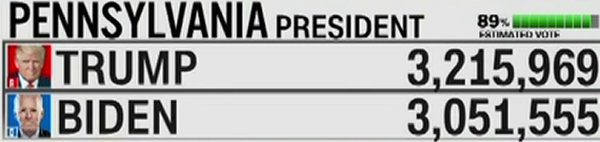
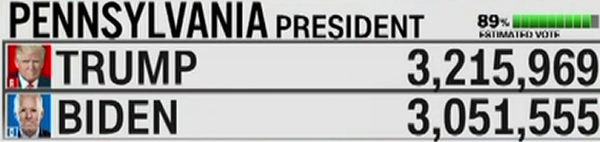
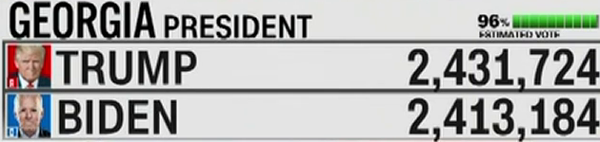
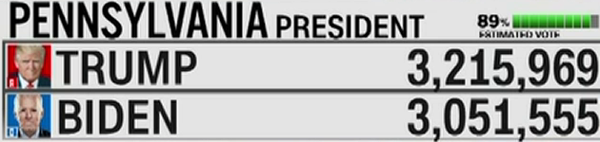
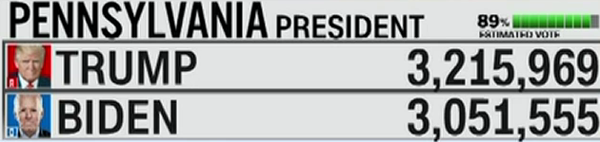
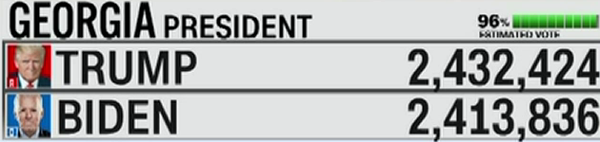
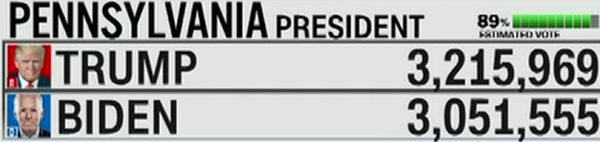
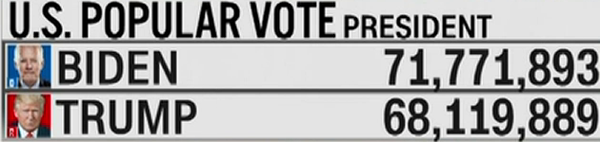
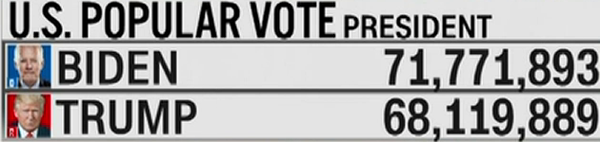

In [6]:
subcrops = [Image.open(x).crop((860, 910, 1490, 1060)) for x in df.localThumb[:9]]
plot_images(subcrops, labels=df.localThumb[:9])

As the news sticker is always located at the same place, it's really a no brainer. We will now rely on Tesseract to transform those images into meaningful texts and numbers.

In [7]:
from pytesseract import image_to_string

image_to_string(subcrops[0])

' \n\x0c'

Well... Tesseract gets better results only if the image contains well organized text and no graphics. Let's continue to take advantage of the fixed location of those fields.

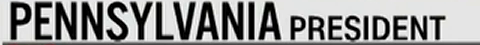

In [8]:
im = Image.open(df.localThumb[0])
im.crop((860, 910, 1340, 955))

In [9]:
image_to_string(im.crop((860, 910, 1340, 955)))

'PENNSYLVANIA presipent\n\x0c'

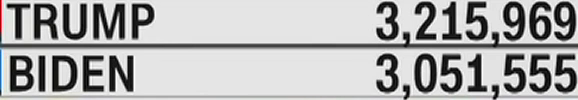

In [10]:
im.crop((912, 960, 1490, 1060))

In [11]:
image_to_string(im.crop((912, 960, 1490, 1060)))

'TRUMP\nBIDEN\n\nGo|Go\n‘Olr\n=\n\n(051,555\n\x0c'

This is quite deceptive, but before turning to more advance methods, let's try filtering the images a bit more. One method consists of removing the lines using morphological operators.

In [12]:
from PIL import ImageFilter
from skimage.morphology import black_tophat, rectangle

def remove_lines(z):
    zbw = (z.convert('L')
            .filter(ImageFilter.MedianFilter(size = 3))
      )
    zbt = 255 - black_tophat(np.asarray(zbw), rectangle(1, 100))
    zimg = Image.fromarray(zbt)
    return zimg

Here we are transforming the images in grayscale, filtering them with a median (it never hurts anyway).
Next, a [back tophat filter](https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_morphology.html#black-tophat) is all we need to remove the long lines in our cropped images.

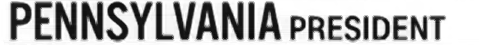

In [13]:
remove_lines(im.crop((860, 910, 1340, 955)))

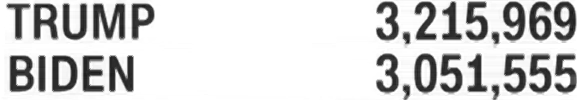

In [14]:
remove_lines(im.crop((912, 960, 1490, 1060)))

In [15]:
txt = image_to_string(remove_lines(im.crop((860, 910, 1340, 955))))
txt.strip()

'PENNSYLVANIA presipent'

In [16]:
txt = image_to_string(remove_lines(im.crop((912, 960, 1490, 1060))))
txt.strip()

'TRUMP 3,215,969\nBIDEN 3,051,555'

There are still a few mistakes, but it is now much much better ! At least, the candidate names and numbers are now retrieved.

# Assembling everything back together

In [17]:
txt_states = [image_to_string(
                remove_lines(
                    Image.open(localpath).crop((860, 910, 1340, 955))
                )).strip() for localpath in df.localThumb]

In [18]:
txt_states

['PENNSYLVANIA presipent',
 'PENNSYLVANIA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'PENNSYLVANIA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'U.S. POPULAR VOTE presipve',
 'U.S. POPULAR VOTE presipve',
 'ARIZONA presipent',
 'PENNSYLVANIA presipent',
 'ARIZONA presipent',
 'PENNSYLVANIA presipent',
 'ARIZONA presipent',
 'NEVADA presipent',
 'PENNSYLVANIA presipent',
 'PENNSYLVANIA presipent',
 '',
 'NEVADA presipent',
 'PENNSYLVANIA presipent',
 'NEVADA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'U.S. POPULAR VOTE presipe',
 'PENNSYLVANIA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'ARIZONA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'PENNSYLVANIA presipent',
 'PENNSYLVANIA presipent',
 'GEORGIA presipent',
 'NEVADA presipent',
 'GEORGIA presipent',
 'GEORGIA presipent',
 'PENNSYLVANIA presipent',
 'NORTH CAROLINA presipen:',
 'ARIZONA presipent',
 'NEVADA presipent',
 'NORTH CAROLINA presipe

In [19]:
txt_votes = [
    image_to_string(
                remove_lines(
                    Image.open(localpath).crop((912, 960, 1490, 1060))
                )).strip() for localpath in df.localThumb
]

In [20]:
txt_votes

['TRUMP 3,215,969\nBIDEN 3,051,555',
 'TRUMP 3,215,969\nBIDEN 3,051,555',
 'TRUMP 2,431,724\nBIDEN 2,413,184',
 'TRUMP 3,215,969\nBIDEN 3,051,555',
 'TRUMP 3,215,969\nBIDEN 3,051,555',
 'TRUMP 2,432,424\nBIDEN 2,413,836',
 'TRUMP 3,215,969\nBIDEN 3,051,555',
 'BIDEN 11,771,893\nTRUMP 68,119,889',
 'BIDEN 11,771,893\nTRUMP 68,119,889',
 'BIDEN 1,469,341\nTRUMP 1,400,951',
 'TRUMP 3,224,422\nBIDEN 3,088,796',
 'BIDEN 1,469,341\nTRUMP 1,400,951',
 'TRUMP 3,228,946\nBIDEN 3,113,877',
 'BIDEN 1,469,341\nTRUMP 1,400,951',
 'DEN 604,251\nTRUMP 592.813',
 'TRUMP 3,232,066\nBIDEN 3,120,697',
 'TRUMP 3,234,183\nBIDEN 3,125,494',
 '',
 'DEN 604,251\nTRUMP 592.813',
 'TRUMP 3,240,358\nBIDEN 3,142,450',
 'DEN 604,251\nTRUMP 592.813',
 'TRUMP 2,439,678\nBIDEN 2,430,153',
 'TRUMP 3,247,808\nBIDEN 3,157,266',
 'BIDEN 73,141,513\nTRUMP 69,198,682',
 'TRUMP 3,264,187\nBIDEN 3,200,462',
 'TRUMP 2,445,539\nBIDEN 2,441,904',
 'TRUMP 3,270,273\nBIDEN 3,217,052',
 '',
 'TRUMP 2,447,223\nBIDEN 2,445,321',
 'T

In [21]:
import re

In [22]:
votes = [re.findall('([A-Z]+) (\d+)', line.replace(',', '')) for line in txt_votes]
votes

[[('TRUMP', '3215969'), ('BIDEN', '3051555')],
 [('TRUMP', '3215969'), ('BIDEN', '3051555')],
 [('TRUMP', '2431724'), ('BIDEN', '2413184')],
 [('TRUMP', '3215969'), ('BIDEN', '3051555')],
 [('TRUMP', '3215969'), ('BIDEN', '3051555')],
 [('TRUMP', '2432424'), ('BIDEN', '2413836')],
 [('TRUMP', '3215969'), ('BIDEN', '3051555')],
 [('BIDEN', '11771893'), ('TRUMP', '68119889')],
 [('BIDEN', '11771893'), ('TRUMP', '68119889')],
 [('BIDEN', '1469341'), ('TRUMP', '1400951')],
 [('TRUMP', '3224422'), ('BIDEN', '3088796')],
 [('BIDEN', '1469341'), ('TRUMP', '1400951')],
 [('TRUMP', '3228946'), ('BIDEN', '3113877')],
 [('BIDEN', '1469341'), ('TRUMP', '1400951')],
 [('DEN', '604251'), ('TRUMP', '592')],
 [('TRUMP', '3232066'), ('BIDEN', '3120697')],
 [('TRUMP', '3234183'), ('BIDEN', '3125494')],
 [],
 [('DEN', '604251'), ('TRUMP', '592')],
 [('TRUMP', '3240358'), ('BIDEN', '3142450')],
 [('DEN', '604251'), ('TRUMP', '592')],
 [('TRUMP', '2439678'), ('BIDEN', '2430153')],
 [('TRUMP', '3247808'), (

In [23]:
votes = pd.DataFrame(dict(x) for x in votes)
votes

,TRUMP,BIDEN,DEN
0,3215969,3051555,NaN
1,3215969,3051555,NaN
2,2431724,2413184,NaN
3,3215969,3051555,NaN
4,3215969,3051555,NaN
...,...,...,...
114,NaN,NaN,NaN
115,NaN,NaN,NaN
116,NaN,NaN,NaN
117,NaN,NaN,NaN


Let's fix some mispelling by renaming the 'DEN' column to 'BIDEN'

In [24]:
votes['BIDEN'] = votes['BIDEN'].where(votes['DEN'].isna(), other=votes['DEN'])
del votes['DEN']
votes

,TRUMP,BIDEN
0,3215969,3051555
1,3215969,3051555
2,2431724,2413184
3,3215969,3051555
4,3215969,3051555
...,...,...
114,NaN,NaN
115,NaN,NaN
116,NaN,NaN
117,NaN,NaN


It's time to group everything together

In [25]:
votes.index = df.index
df = df.assign(state=txt_states).join(votes)
df[['state', 'BIDEN', 'TRUMP']]

,state,BIDEN,TRUMP
firstPublishedDate,,,
2020-11-05T12:01:16.375Z,PENNSYLVANIA presipent,3051555,3215969
2020-11-05T12:43:32.334Z,PENNSYLVANIA presipent,3051555,3215969
2020-11-05T13:25:56.060Z,GEORGIA presipent,2413184,2431724
2020-11-05T13:39:20.601Z,PENNSYLVANIA presipent,3051555,3215969
2020-11-05T13:58:33.989Z,PENNSYLVANIA presipent,3051555,3215969
...,...,...,...
2020-11-08T02:32:48.342Z,al Beas de a,NaN,NaN
2020-11-08T02:36:49.235Z,al Baas d= a,NaN,NaN
2020-11-08T03:09:52.899Z,al Baas de,NaN,NaN


In [26]:
import matplotlib
from matplotlib import pyplot as plt

plt.style.use('seaborn')

%matplotlib notebook

Let's now plot the evolution of votes in Pennsylvania

<IPython.core.display.Javascript object>


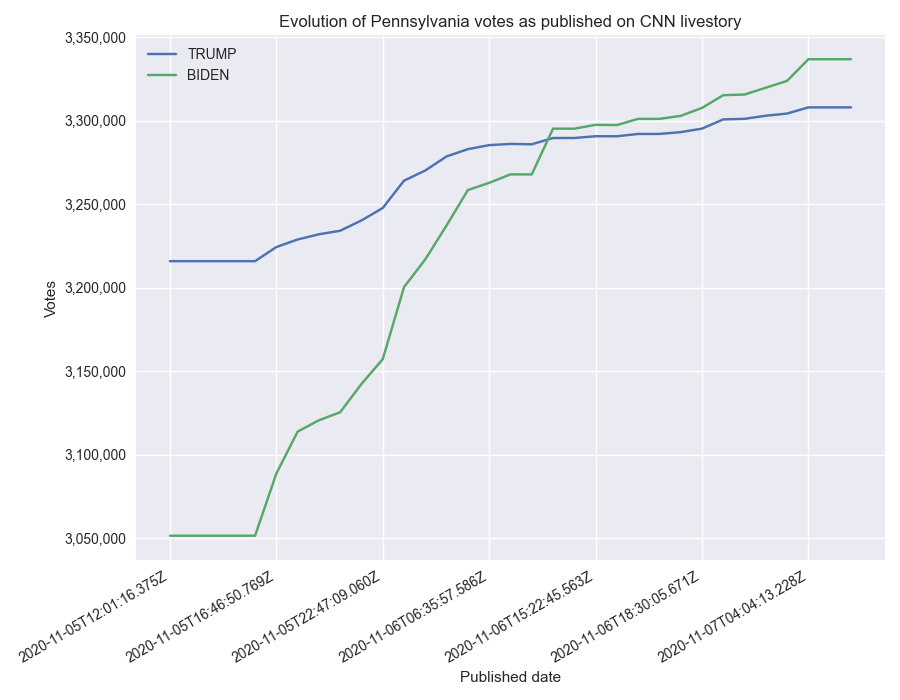

In [31]:
votes_pennsylvania = df.loc[df.state.str.contains('PENNSYLVANIA'), ['TRUMP', 'BIDEN']].astype('int')

fig, ax = plt.subplots(figsize=(9,7))
votes_pennsylvania.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Evolution of Pennsylvania votes as published on CNN livestory')
plt.ylabel('Votes')
plt.xlabel('Published date')
fig.autofmt_xdate()
plt.tight_layout()

# Conclusion

We uses video snapshots posted on a news website, and show how we can take advantage of the news sticker at the bottom to extract the number of votes with a timestamp. We found a few states, as they were more often discussed during the special edition. But we could also have dig deeper in the analysis by looking at all the videos. While speakers were debating, the news sticker was updated regularly and I am pretty sure more datas can even been found there. The methodology would remains the same except we'll have to process every n frames from the video. I guess you got the idea. I hope that this post give you some inspiration on how to use images to collect even more datas.